# Example of usage of pseudo-Boolean polynomials applied on image patches to detect edges 

Install python libraries 

In [112]:

# !pip install -r requirements.txt

Import libraries 

In [113]:
import sys
import os
import cv2
import numpy as np
import json
import pandas as pd
import time
from matplotlib import pyplot as plt

Import pBp creation functions

In [114]:
from pbp import create_perm, create_coeffs_matrix, create_variable_matrix, BIT_ORDER

Import image utilities

In [115]:
from image_utils.im_filters import group_ranges, pixelate_bin, kmeans_color_quantization, image_gaussian, resize_img

Support function for showing an image 

In [116]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

Function to calculate the degrees of terms in a pBp 

In [117]:
def deg_greater_than(numbers, p):
    # binary_numbers = np.array([bin(num).count('1') for num in numbers])
    # deg_greater = False
    # for num in numbers:
    #     if bin(num).count('1') >= p:
    #         deg_greater = True
    #         break
    binary_numbers = np.array([bin(num).count('1') for num in numbers])
    deg_greater = np.any(binary_numbers >= p)

    return deg_greater


1. Create a variable and coeffs matrix. 

2. Nullify variables corresponding to the coefficients==0 of the polynomial. 

3. Calculate the degrees of the variables left

In [118]:
def process_degs(c, p):
    perm_c = create_perm(c)
    coeffs_c = create_coeffs_matrix(c, perm_c)
    
    y = create_variable_matrix(c, perm_c)
    zs = np.where(coeffs_c[1:] == 0)
    y[zs] = 0
    # no need to calculate whole pBp since we are only interested in the degree
    # uniq_y = np.unique(y)
    deg = deg_greater_than([y.max()], p)
    return deg
    
    

Function to annotate a high degree patch 

In [119]:
def annotate_mask(mask, i, step_y, j, step_x, value=255):
    # cv2.rectangle(mask, (i, j), (i + step_y, j + step_x), 250, -1)
    mask[i, j] = value

Iterate over image patches and calculate degree of polynomial to compare with Threshold p

In [120]:
def get_patch_degs(img_grey, p, n, m, step_x=2, step_y=2, rotation=False):
    windows = []
    mask = np.full(img_grey.shape, 0, np.uint8)
    h, w = img_grey.shape[:2]

    for i in range(0, h - n + 1, step_y):
        for j in range(0, w - m + 1, step_x):
            i_n = i + n
            j_m = j + m

            window = img_grey[i:i_n, j:j_m]
            if not window.any():
                continue

            # pbp = create_pbp(window)
            # if pbp.size == 0:
            #     print(window)

            # print(pbp['degree'].max(), p)
            deg = process_degs(window, p)
            
            # if pbp['degree'].max() > p:
            if deg:
                annotate_mask(mask, i, step_y, j, step_x)
            elif rotation:
                deg = process_degs(window.T, p)
                if deg:
                    annotate_mask(mask, i, step_y, j, step_x)
    return mask


Driver function

In [121]:
def process_file(im_p, **kwargs):
    if not os.path.exists(im_p):
        return 
        
    print("[INFO] processing file {}".format(im_p))
    target_mask = ".".join(im_p.replace("images", "masks").split(".")[:-1])

    target_mask_img = None
    if os.path.exists("{}.jpg".format(target_mask)):
        target_mask_img  = cv2.imread("{}.jpg".format(target_mask))
    elif os.path.exists("{}.png".format(target_mask)):
        target_mask_img  = cv2.imread("{}.png".format(target_mask))
    
    
    img = cv2.imread(im_p)
    img = resize_img(img)

    print("Input image")
    show_image(img)
    if target_mask_img is not None:
        print("Target mask")
        show_image(target_mask_img)

    if kwargs.get("gaussian"):
        img = image_gaussian(img, (3, 3))

    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if kwargs.get("pixel_range"):
        div = kwargs.get("pixel_range")
        if div == "kmeans":
            img_grey = kmeans_color_quantization(img_grey)
        elif div == "pix":
            img_grey = pixelate_bin(img_grey, 10, 100)
        else:
            img_grey = img_grey // div * div + div // 2
    else:
        th, img_grey = cv2.threshold(img_grey, 128, 255, cv2.THRESH_OTSU)
    
    p = int(kwargs.get("window_height") * kwargs.get("p"))
    mask = get_patch_degs(img_grey, p, kwargs.get("window_height"), kwargs.get("window_width"), kwargs.get("step_size_x"), kwargs.get("step_size_y"), kwargs.get("rotation"))
    
    return mask


[INFO] processing file examples/images/elephant.png
Input image


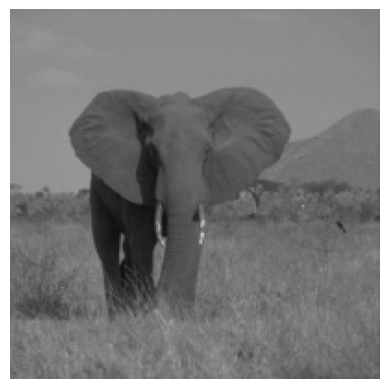

PBp image edge mask


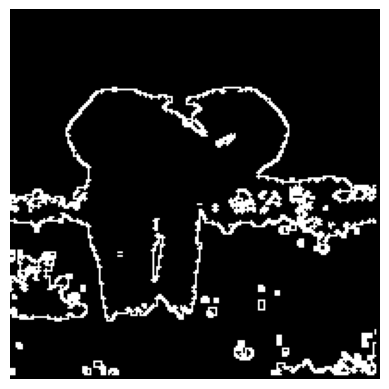

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.8      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 4.1434 seconds



In [122]:
kwargs =  {
        "window_height": 3, # the height of the window in pixels to use for the edge detection by making a pseudo-Boolean polynomial 
        "window_width": 3, # the width of the window in pixels to use for the edge detection by making a pseudo-Boolean polynomial
        "step_size_y": 1, # how to step through the y axis across the image plane when extracting windows
        "step_size_x": 1, # how to step through the x axis across the image plane when extracting windows
        "p": 0.8, # threshold for binary classification of blob/edge regions. [0.1 - 0.9]
        "rotation": True, # if to check the patche's pBp degree in normal and transposed form
        "gaussian": True, # if to apply a gaussian blur to the image before edge detection
        "pixel_range": False, # if to apply a pixel range filter to the image before edge detection [kmeans to use a kmeans_color_quantization filter, pixelate_bin to pixalate the image, <number> to apply a threshold filter], otherwise use cv2.THRESH_OTSU
        "im_p": "examples/images/elephant.png", # image path
        "fine": False # if to use the fine-grained version of the algorithm TODO
    }

start_time = time.perf_counter()
mask = process_file(**kwargs)
last = time.perf_counter() - start_time
if mask is not None:
    print("PBp image edge mask")
    show_image(mask)
    print(pd.DataFrame([kwargs]).drop(["fine", "im_p"], axis=1))
    print(f"Time taken: {last:0.4f} seconds")
    print("="*80)
    print()

Get preset arguments for test runs. Process each arg set and print the results.

[INFO] processing file examples/images/sam.png
Input image


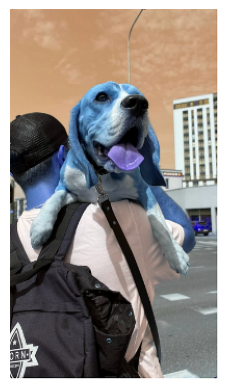

Target mask


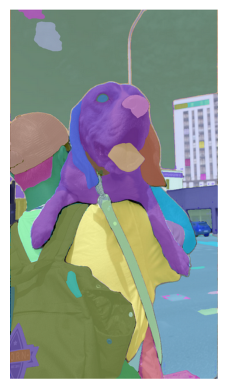

PBp image edge mask


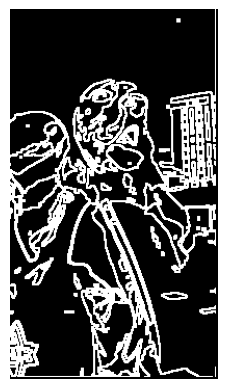

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True           80  
Time taken: 10.0317 seconds

[INFO] processing file examples/images/lady.png
Input image


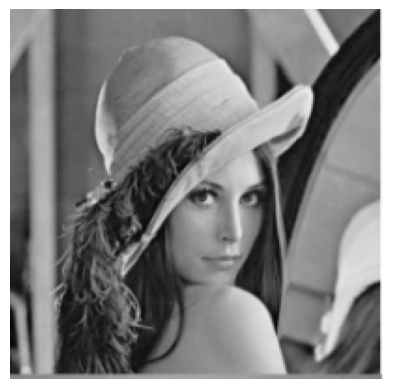

PBp image edge mask


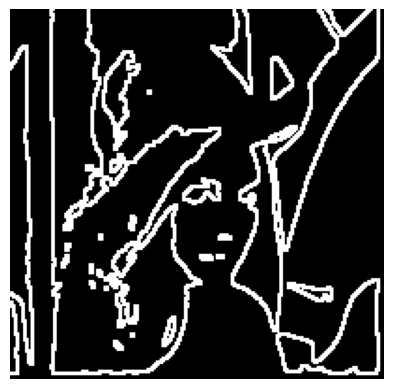

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 2.3341 seconds

[INFO] processing file examples/images/bjorke_1.png
Input image


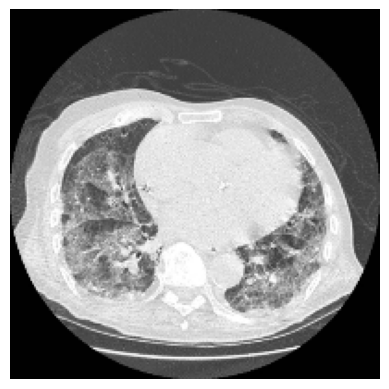

PBp image edge mask


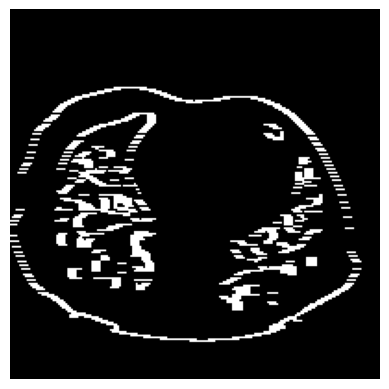

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0        False     False  
Time taken: 2.6783 seconds

[INFO] processing file examples/images/bjorke_2.png
Input image


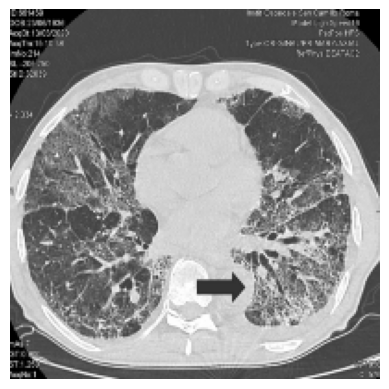

PBp image edge mask


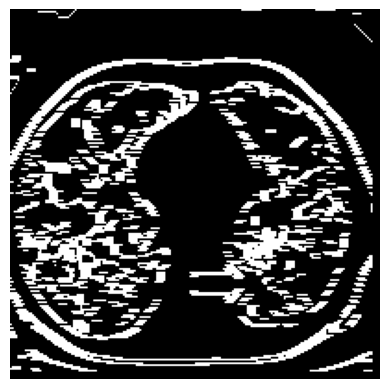

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 3.7115 seconds

[INFO] processing file examples/images/bjorke_3.png
Input image


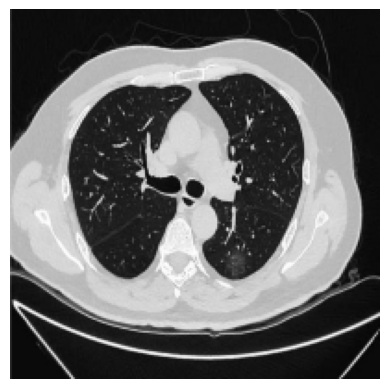

PBp image edge mask


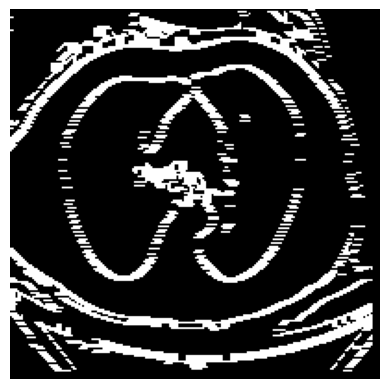

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 3.3913 seconds

[INFO] processing file examples/images/bjorke_5.png
Input image


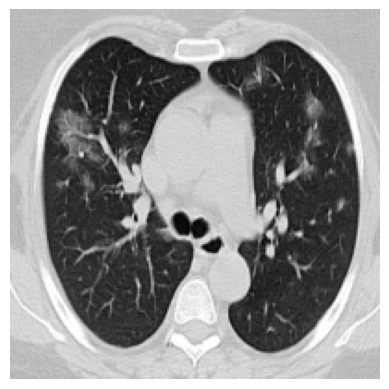

PBp image edge mask


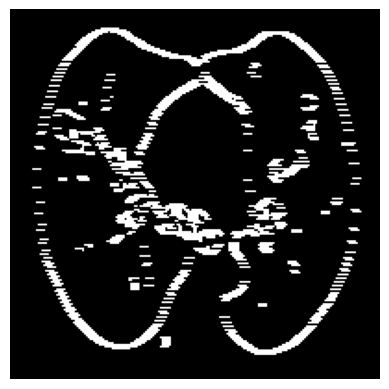

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 3.4357 seconds

[INFO] processing file examples/images/bjorke_6.png
Input image


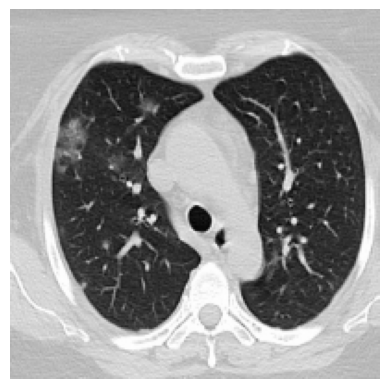

PBp image edge mask


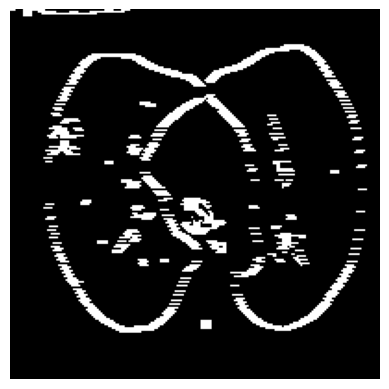

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 3.4900 seconds

[INFO] processing file examples/images/bjorke_7.png
Input image


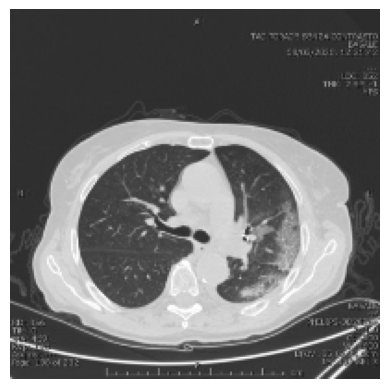

PBp image edge mask


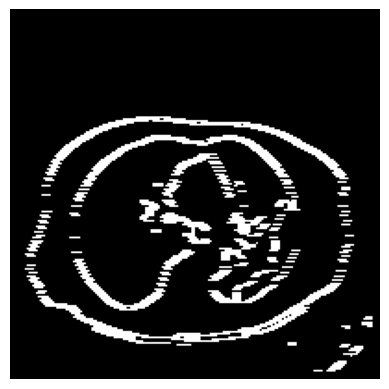

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 3.4507 seconds

[INFO] processing file examples/images/bjorke_8.png
Input image


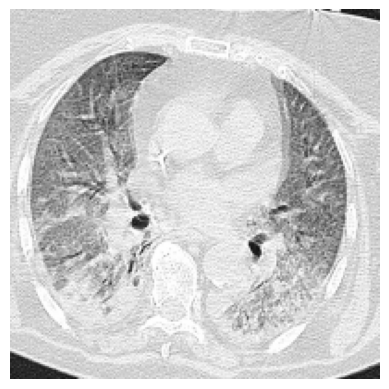

PBp image edge mask


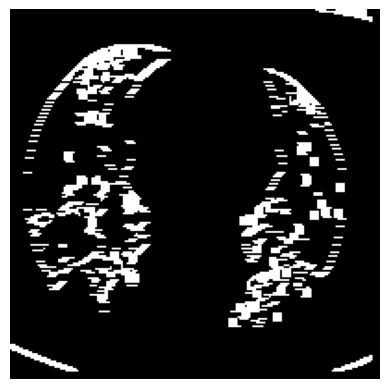

   window_height  window_width  step_size_y  step_size_x    p  gaussian  \
0              5             5            1            1  0.9      True   

   pixel_range  rotation  
0           80     False  
Time taken: 6.4872 seconds

[INFO] processing file examples/images/wiki-sample-edge.png
Input image


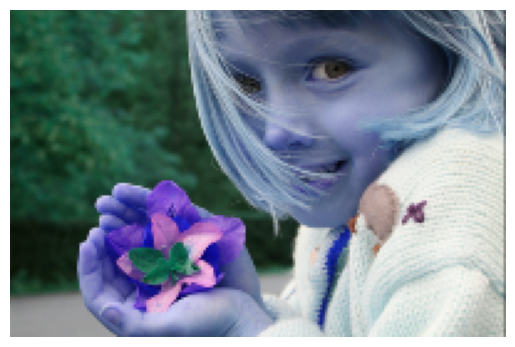

PBp image edge mask


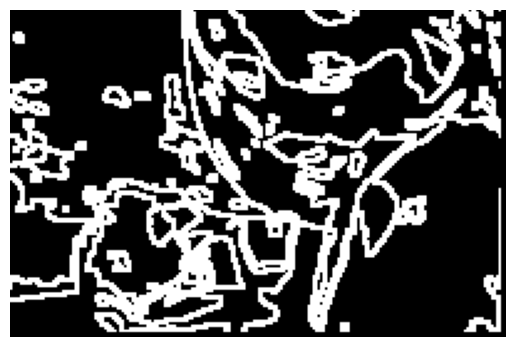

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True           70  
Time taken: 6.1322 seconds

[INFO] processing file examples/images/wiki-sample-edge.png
Input image


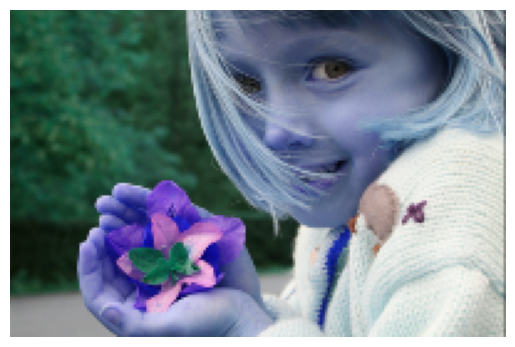

PBp image edge mask


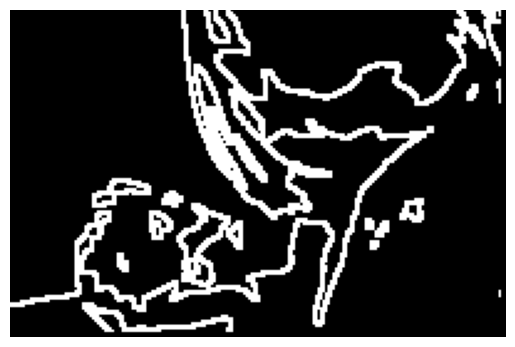

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 3.8908 seconds

[INFO] processing file examples/images/lady-noisy.png
Input image


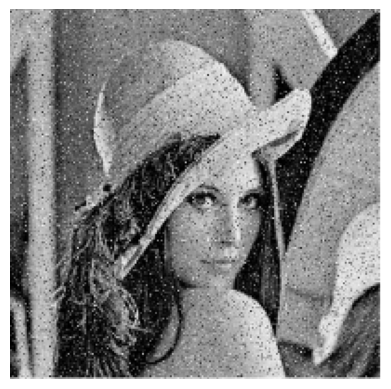

PBp image edge mask


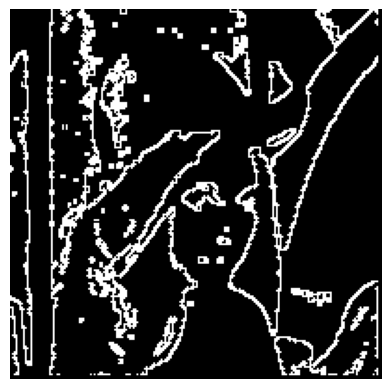

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.9      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 5.2346 seconds

[INFO] processing file examples/images/sam.png
Input image


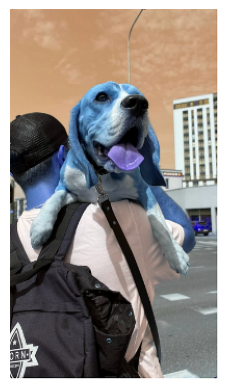

Target mask


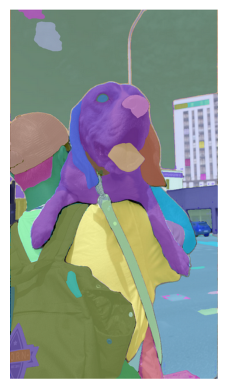

PBp image edge mask


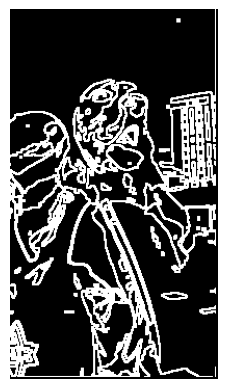

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True           80  
Time taken: 11.5399 seconds

[INFO] processing file examples/images/camera-man.png
Input image


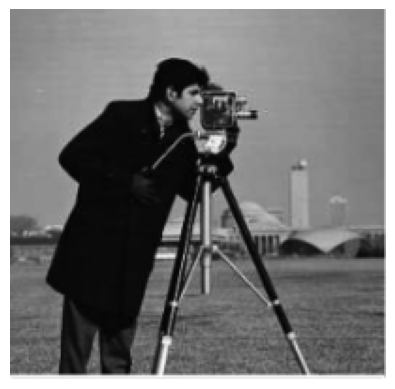

PBp image edge mask


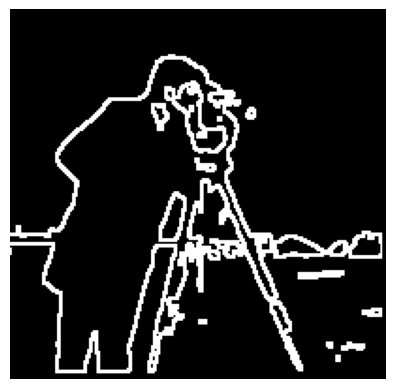

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.6      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 2.7650 seconds

[INFO] processing file examples/images/prasath_multiscale_2020-grad-map.png
Input image


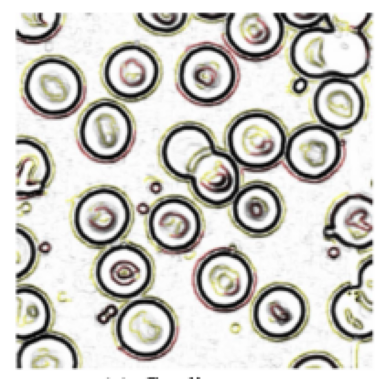

PBp image edge mask


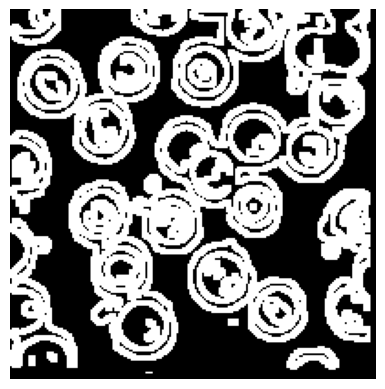

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.4      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 2.1829 seconds

[INFO] processing file examples/images/prasath_multiscale_2020.png
Input image


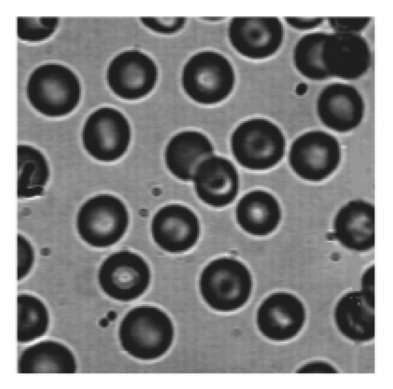

PBp image edge mask


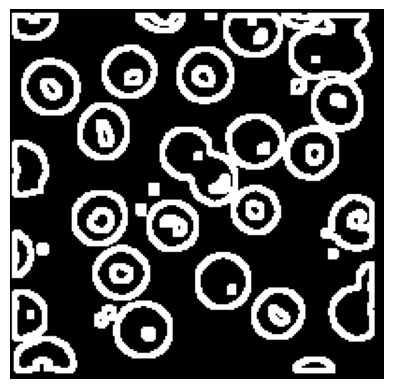

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.4      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 2.0101 seconds

[INFO] processing file examples/images/flower.png
Input image


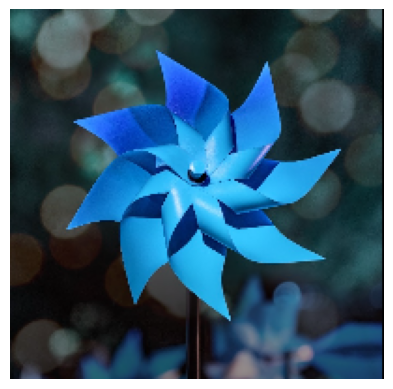

Target mask


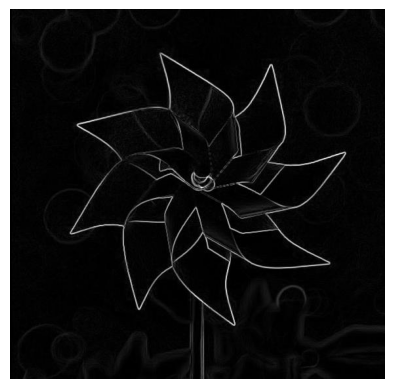

PBp image edge mask


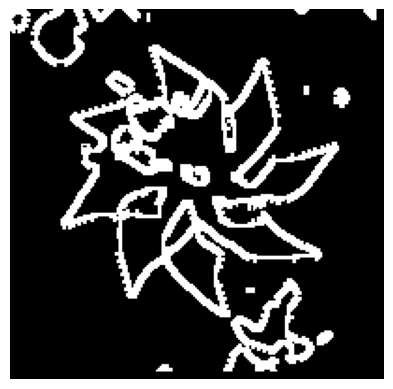

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              5             5            1            1  0.7      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 4.3947 seconds

[INFO] processing file examples/images/fruit.png
Input image


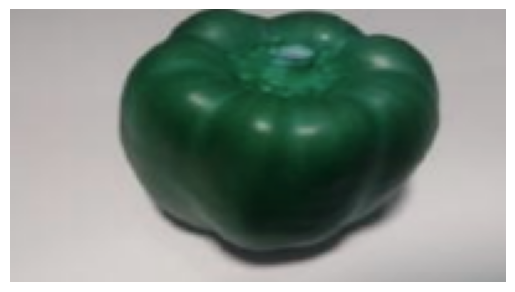

Target mask


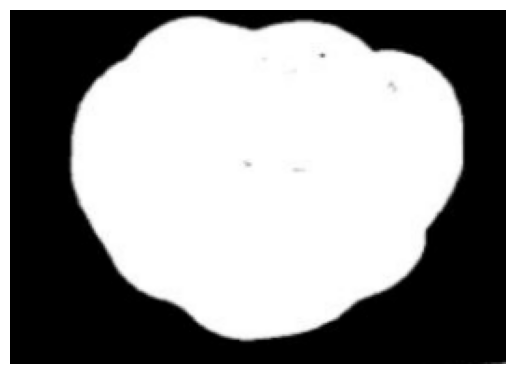

PBp image edge mask


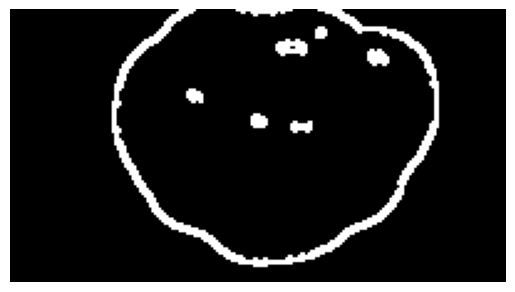

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.6      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 1.4437 seconds

[INFO] processing file examples/images/leaf.png
Input image


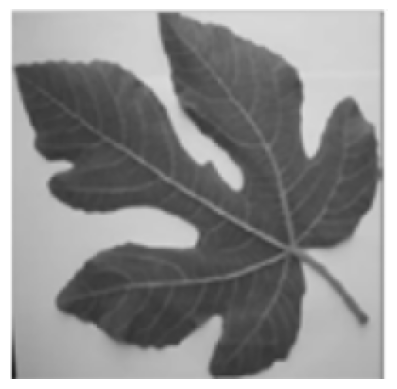

PBp image edge mask


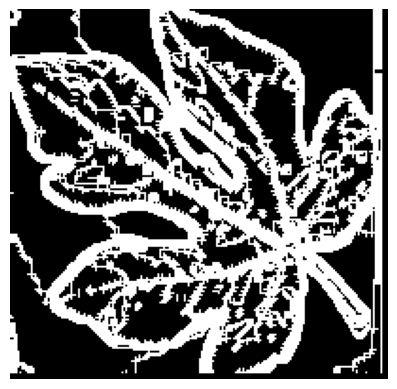

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.9      True   

   gaussian pixel_range  
0      True      kmeans  
Time taken: 3.7566 seconds

[INFO] processing file examples/images/leaf.png
Input image


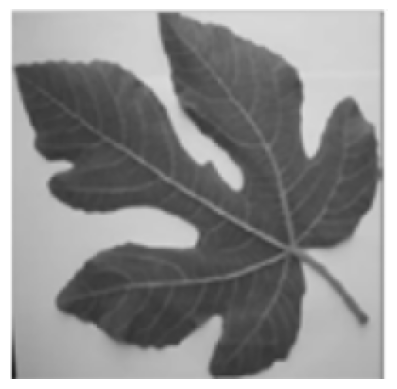

PBp image edge mask


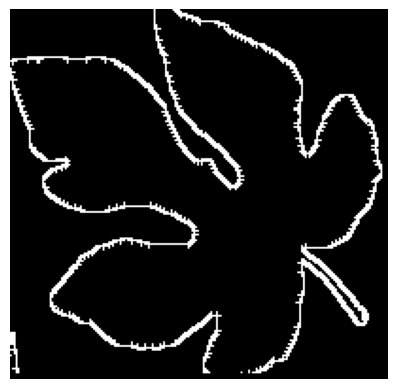

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.9      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 2.6018 seconds

[INFO] processing file examples/images/leaf.png
Input image


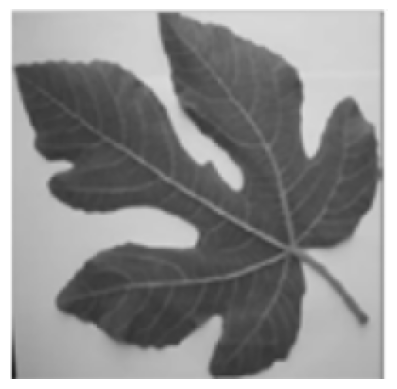

PBp image edge mask


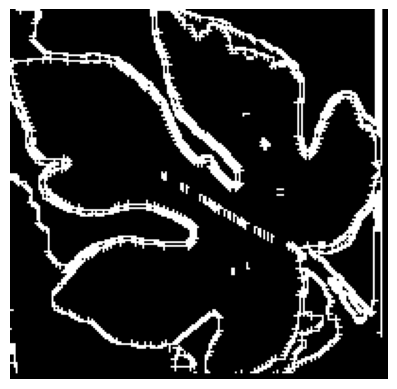

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              4             4            1            1  0.9      True   

   gaussian  pixel_range  
0      True           80  
Time taken: 3.9155 seconds

[INFO] processing file examples/images/hyena-pack.png
Input image


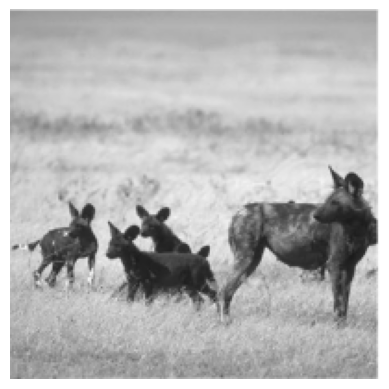

PBp image edge mask


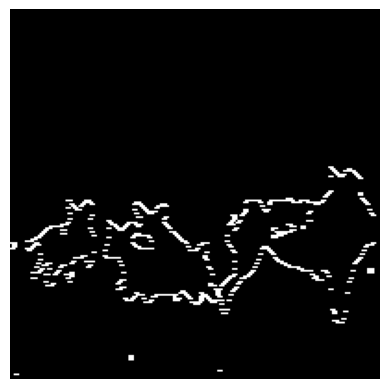

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.7     False   

   gaussian  pixel_range  
0      True        False  
Time taken: 0.5309 seconds

[INFO] processing file examples/images/elephant.png
Input image


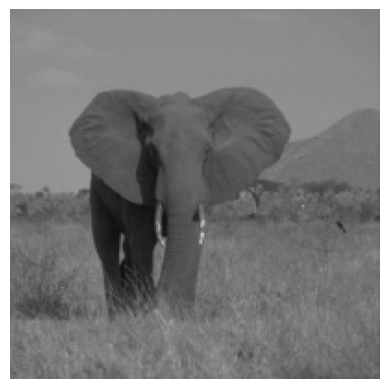

PBp image edge mask


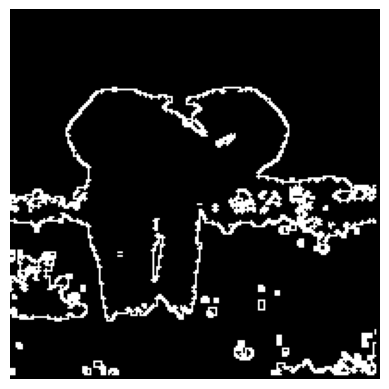

   window_height  window_width  step_size_y  step_size_x    p  rotation  \
0              3             3            1            1  0.8      True   

   gaussian  pixel_range  
0      True        False  
Time taken: 1.8488 seconds



In [123]:
with open("args.json") as fp:
    examples = json.load(fp)
    fp.close()

for kwargs in examples:
    
    try:
        start_time = time.perf_counter()
        mask = process_file(**kwargs)
        last = time.perf_counter() - start_time
        if mask is not None:
            print("PBp image edge mask")
            show_image(mask)
            print(pd.DataFrame([kwargs]).drop(["fine", "im_p"], axis=1))
            print(f"Time taken: {last:0.4f} seconds")
            print("="*80)
            print()
    except Exception as err:
        print(err)
    # break 